In [ ]:
""" AUTOR:JHONATAN MARTINEZ
RECOMIENDO CREAR UNA BASE DE DATOS USANDO pgAdmin 4 y en un query ejecutar CREATE EXTENSION postgis, saber cuales son tu usuario contraseña y nombre
""""

In [1]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, ForeignKey, Text, LargeBinary
from geoalchemy2 import Geometry
from sqlalchemy.orm import relationship, declarative_base
from datetime import date

Base = declarative_base()

# 1. Tabla Excavaciones
class Excavacion(Base):
    __tablename__ = 'excavaciones'
    id_excavacion = Column(Integer, primary_key=True)
    nombre_excavacion = Column(String(255), nullable=False)
    tipo_excavacion = Column(String(100), nullable=False)
    ubicacion = Column(Geometry('Point', srid=4326))
    fecha_inicio = Column(Date)
    fecha_fin = Column(Date)
    profundidad_total = Column(Float)
    estatus = Column(String(50))
    descripcion = Column(Text)

    # Relaciones
    muestras = relationship("Muestra", back_populates="excavacion")
    perforaciones = relationship("Perforacion", back_populates="excavacion")
    informes = relationship("InformeGeologico", back_populates="excavacion")
    actividades = relationship("ActividadExploracion", back_populates="excavacion")
    zonas = relationship("ZonaEstratografica", secondary="excavacion_zona")

# 2. Tabla Muestras
class Muestra(Base):
    __tablename__ = 'muestras'
    id_muestra = Column(Integer, primary_key=True)
    id_excavacion = Column(Integer, ForeignKey('excavaciones.id_excavacion'))
    tipo_muestra = Column(String(100))
    ubicacion = Column(Geometry('Point', srid=4326))
    fecha_recoleccion = Column(Date)
    descripcion = Column(Text)
    profundidad_muestra = Column(Float)

    # Relaciones
    excavacion = relationship("Excavacion", back_populates="muestras")
    minerales = relationship("Mineral", secondary="muestra_mineral")
    analisis = relationship("AnalisisQuimico", back_populates="muestra")
    control_quality = relationship("ControlQuality", back_populates="muestra")

# 3. Tabla Minerales
class Mineral(Base):
    __tablename__ = 'minerales'
    id_min = Column(Integer, primary_key=True)
    nombre_min = Column(String(255), nullable=False)
    composicion_quimica = Column(String(255))
    descripcion = Column(Text)
    valor_mercado = Column(Float)
    sistemas_cristalinos = Column(String(100))
    color = Column(String(50))

    # Relaciones
    muestras = relationship("Muestra", secondary="muestra_mineral")

# 4. Tabla MuestraMineral
class MuestraMineral(Base):
    __tablename__ = 'muestra_mineral'
    id_muestra = Column(Integer, ForeignKey('muestras.id_muestra'), primary_key=True)
    id_min = Column(Integer, ForeignKey('minerales.id_min'), primary_key=True)
    cantidad = Column(Float)
    concentracion = Column(Float)
    observaciones = Column(Text)

# 5. Tabla Perforaciones
class Perforacion(Base):
    __tablename__ = 'perforaciones'
    id_perforacion = Column(Integer, primary_key=True)
    id_excavacion = Column(Integer, ForeignKey('excavaciones.id_excavacion'))
    profundidad = Column(Float)
    ubicacion = Column(Geometry('Point', srid=4326))
    fecha_perforacion = Column(Date)
    tipo_perforacion = Column(String(100))
    estatus = Column(String(50))
    descripcion = Column(Text)

    # Relaciones
    excavacion = relationship("Excavacion", back_populates="perforaciones")

# 6. Tabla InformesGeologicos
class InformeGeologico(Base):
    __tablename__ = 'informes_geologicos'
    id_informe = Column(Integer, primary_key=True)
    id_excavacion = Column(Integer, ForeignKey('excavaciones.id_excavacion'))
    fecha_informe = Column(Date)
    descripcion = Column(Text)
    archivo_pdf = Column(LargeBinary)
    recomendaciones = Column(Text)

    # Relaciones
    excavacion = relationship("Excavacion", back_populates="informes")

# 7. Tabla ControlQuality
class ControlQuality(Base):
    __tablename__ = 'control_quality'
    id_control = Column(Integer, primary_key=True)
    id_muestra = Column(Integer, ForeignKey('muestras.id_muestra'))
    fecha_control = Column(Date)
    resultado = Column(String(50))
    comentarios = Column(Text)

    # Relaciones
    muestra = relationship("Muestra", back_populates="control_quality")

# 8. Tabla ZonasEstratigraficas
class ZonaEstratografica(Base):
    __tablename__ = 'zonas_estratigraficas'
    id_zona = Column(Integer, primary_key=True)
    nombre_zona = Column(String(255), nullable=False)
    tipo_formacion = Column(String(255))
    grosor = Column(Float)
    espesor_maximo = Column(Float)
    ubicacion = Column(Geometry('Polygon', srid=4326))
    fecha_formacion = Column(Date)

# Tabla intermedia Excavacion_Zona
class ExcavacionZona(Base):
    __tablename__ = 'excavacion_zona'
    id_excavacion = Column(Integer, ForeignKey('excavaciones.id_excavacion'), primary_key=True)
    id_zona = Column(Integer, ForeignKey('zonas_estratigraficas.id_zona'), primary_key=True)

# 9. Tabla AnalisisQuimico
class AnalisisQuimico(Base):
    __tablename__ = 'analisis_quimicos'
    id_analisis = Column(Integer, primary_key=True)
    id_muestra = Column(Integer, ForeignKey('muestras.id_muestra'))
    fecha_analisis = Column(Date)
    tipo_analisis = Column(String(255))
    resultado = Column(Text)
    concentracion_elementos = Column(Text)

    # Relaciones
    muestra = relationship("Muestra", back_populates="analisis")

# 10. Tabla ActividadExploracion
class ActividadExploracion(Base):
    __tablename__ = 'actividades_exploracion'
    id_actividad = Column(Integer, primary_key=True)
    id_excavacion = Column(Integer, ForeignKey('excavaciones.id_excavacion'))
    tipo_actividad = Column(String(100))
    descripcion = Column(Text)
    fecha_inicio = Column(Date)
    fecha_fin = Column(Date)
    estatus = Column(String(50))

    # Relaciones
    excavacion = relationship("Excavacion", back_populates="actividades")


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
host="localhost"
port=5432
username="postgres"
password="121212"
database="GEO"

In [4]:
from sqlalchemy import event
from psycopg2.extensions import register_type, UNICODE

In [5]:
def set_client_encoding(dbapi_connection, connection_record):
    register_type(UNICODE, dbapi_connection)

In [6]:
engine=create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}", echo=True,pool_pre_ping=True)
event.listen(engine, 'connect', set_client_encoding)
Base.metadata.create_all(engine)

2024-11-22 00:06:27,844 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-11-22 00:06:27,844 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-22 00:06:27,846 INFO sqlalchemy.engine.Engine select current_schema()
2024-11-22 00:06:27,846 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-22 00:06:27,847 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-11-22 00:06:27,848 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-22 00:06:27,849 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-22 00:06:27,852 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [7]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, ForeignKey, Text, Boolean, LargeBinary
from geoalchemy2 import Geometry
from sqlalchemy.orm import relationship, declarative_base, sessionmaker
from datetime import date
from geoalchemy2 import WKTElement

In [9]:
Session = sessionmaker(bind=engine)
session = Session()

In [10]:
excavaciones = [
    Excavacion(
        nombre_excavacion="Sondeo Perforación 1A",
        tipo_excavacion="Sondeo",
        ubicacion=WKTElement('POINT(-74.0586 4.5709)', srid=4326),
        fecha_inicio=date(2023, 1, 10),
        fecha_fin=date(2023, 5, 25),
        profundidad_total=100,
        estatus="Completada",
        descripcion="Sondeo realizado para evaluación de mineral de oro en la zona Norte de Antioquia"
    ),
    Excavacion(
        nombre_excavacion="Perforación 2B",
        tipo_excavacion="Perforación",
        ubicacion=WKTElement('POINT(-73.8153 5.0938)', srid=4326),
        fecha_inicio=date(2023, 2, 15),
        fecha_fin=date(2023, 8, 30),
        profundidad_total=150,
        estatus="En Progreso",
        descripcion="Perforación para evaluación de mineral de cobre en el área central de Boyacá"
    ),
    Excavacion(
        nombre_excavacion="Perforación 3C",
        tipo_excavacion="Perforación",
        ubicacion=WKTElement('POINT(-75.2108 6.2031)', srid=4326),
        fecha_inicio=date(2023, 3, 5),
        fecha_fin=date(2023, 7, 10),
        profundidad_total=200,
        estatus="Completada",
        descripcion="Exploración de cobre en la región de la Costa Atlántica"
    ),
    Excavacion(
        nombre_excavacion="Sondeo 4D",
        tipo_excavacion="Sondeo",
        ubicacion=WKTElement('POINT(-73.8045 5.0897)', srid=4326),
        fecha_inicio=date(2023, 4, 1),
        fecha_fin=date(2023, 6, 20),
        profundidad_total=80,
        estatus="Completada",
        descripcion="Sondeo exploratorio para evaluar concentración de oro en el noroccidente de Cundinamarca."
    ),
    Excavacion(
        nombre_excavacion="Perforación 5E",
        tipo_excavacion="Perforación",
        ubicacion=WKTElement('POINT(-75.6004 6.5001)', srid=4326),
        fecha_inicio=date(2023, 5, 10),
        fecha_fin=date(2023, 9, 15),
        profundidad_total=250,
        estatus="En Progreso",
        descripcion="Perforación profunda para evaluar posibles depósitos de cobre en el sur de Bolívar."
    ),
]

session.bulk_save_objects(excavaciones)

# 2. Muestras
muestras = [
    Muestra(
        id_excavacion=1,  # Excavación Sondeo 1A
        tipo_muestra="Muestra de Roca",
        ubicacion=WKTElement('POINT(-74.0587 4.5708)', srid=4326),
        fecha_recoleccion=date(2023, 2, 5),
        descripcion="Muestra de roca extraída de la capa superficial en la excavación Sondeo 1A",
        profundidad_muestra=15
    ),
    Muestra(
        id_excavacion=2,  # Excavación Perforación 2B
        tipo_muestra="Muestra de Suelo",
        ubicacion=WKTElement('POINT(-73.8152 5.0937)', srid=4326),
        fecha_recoleccion=date(2023, 4, 10),
        descripcion="Muestra de suelo obtenida para análisis de concentración de metales pesados",
        profundidad_muestra=20
    ),
    Muestra(
        id_excavacion=3,  # Excavación Perforación 3C
        tipo_muestra="Muestra de Sedimento",
        ubicacion=WKTElement('POINT(-75.2110 6.2030)', srid=4326),
        fecha_recoleccion=date(2023, 6, 1),
        descripcion="Muestra de sedimento recolectada en perforación 3C",
        profundidad_muestra=30
    ),
    Muestra(
        id_excavacion=4,  # Excavación Sondeo 4D
        tipo_muestra="Muestra de Roca",
        ubicacion=WKTElement('POINT(-73.8046 5.0896)', srid=4326),
        fecha_recoleccion=date(2023, 5, 10),
        descripcion="Muestra de roca recogida durante sondeo 4D en el noroccidente de Cundinamarca",
        profundidad_muestra=12
    ),
    Muestra(
        id_excavacion=5,  # Excavación Perforación 5E
        tipo_muestra="Muestra de Suelo",
        ubicacion=WKTElement('POINT(-75.6003 6.5002)', srid=4326),
        fecha_recoleccion=date(2023, 7, 12),
        descripcion="Muestra de suelo tomada de perforación profunda 5E, ubicada en el sur de Bolívar",
        profundidad_muestra=18
    ),
]

session.bulk_save_objects(muestras)

# 3. Minerales
minerales = [
    Mineral(
        nombre_min="Oro",
        composicion_quimica="Au",
        descripcion="El oro es un metal precioso utilizado principalmente en joyería y como reserva de valor.",
        valor_mercado=1900.0,
        sistemas_cristalinos="Cúbico",
        color="Amarillo"
    ),
    Mineral(
        nombre_min="Cobre",
        composicion_quimica="Cu",
        descripcion="El cobre es un metal industrial ampliamente utilizado en electricidad y construcción.",
        valor_mercado=4.5,
        sistemas_cristalinos="Cúbico",
        color="Rojo"
    ),
    Mineral(
        nombre_min="Plata",
        composicion_quimica="Ag",
        descripcion="La plata es un metal precioso usado en joyería, electrónica y monedas.",
        valor_mercado=24.5,
        sistemas_cristalinos="Cúbico",
        color="Blanco Plateado"
    ),
    Mineral(
        nombre_min="Platino",
        composicion_quimica="Pt",
        descripcion="El platino es un metal raro utilizado principalmente en joyería y catalizadores industriales.",
        valor_mercado=1100.0,
        sistemas_cristalinos="Cúbico",
        color="Gris Plateado"
    ),
    Mineral(
        nombre_min="Hierro",
        composicion_quimica="Fe",
        descripcion="El hierro es un metal fundamental para la industria pesada y construcción.",
        valor_mercado=0.12,
        sistemas_cristalinos="Cúbico",
        color="Gris"
    ),
]

session.bulk_save_objects(minerales)

# 4. MuestraMineral
muestra_mineral = [
    MuestraMineral(
        id_muestra=1,  # Muestra de Roca
        id_min=1,  # Mineral Oro
        cantidad=3.5,
        concentracion=0.2,
        observaciones="Alta concentración de oro en la capa superficial"
    ),
    MuestraMineral(
        id_muestra=2,  # Muestra de Suelo
        id_min=2,  # Mineral Cobre
        cantidad=5.0,
        concentracion=1.5,
        observaciones="Muestra tomada de suelo rico en cobre"
    ),
    MuestraMineral(
        id_muestra=3,  # Muestra de Sedimento
        id_min=3,  # Mineral Plata
        cantidad=4.0,
        concentracion=2.3,
        observaciones="Presencia significativa de plata en los sedimentos"
    ),
    MuestraMineral(
        id_muestra=4,  # Muestra de Roca
        id_min=4,  # Mineral Platino
        cantidad=1.2,
        concentracion=0.1,
        observaciones="Pequeñas trazas de platino en la roca"
    ),
    MuestraMineral(
        id_muestra=5,  # Muestra de Suelo
        id_min=5,  # Mineral Hierro
        cantidad=10.0,
        concentracion=5.0,
        observaciones="Suelo con alta concentración de hierro"
    ),
]

session.bulk_save_objects(muestra_mineral)

# 5. Perforaciones
perforaciones = [
    Perforacion(
        id_excavacion=1,
        profundidad=120,
        ubicacion=WKTElement('POINT(-74.0589 4.5710)', srid=4326),
        fecha_perforacion=date(2023, 3, 1),
        tipo_perforacion="Rotativa",
        estatus="Completada",
        descripcion="Perforación realizada para obtener muestras de roca en la zona superficial."
    ),
    Perforacion(
        id_excavacion=2,
        profundidad=150,
        ubicacion=WKTElement('POINT(-73.8154 5.0939)', srid=4326),
        fecha_perforacion=date(2023, 6, 1),
        tipo_perforacion="Percutiva",
        estatus="En Progreso",
        descripcion="Perforación en curso para exploración de mineral de cobre."
    ),
    Perforacion(
        id_excavacion=4,
        profundidad=110,
        ubicacion=WKTElement('POINT(-73.8047 5.0895)', srid=4326),
        fecha_perforacion=date(2023, 5, 5),
        tipo_perforacion="Rotativa",
        estatus="Completada",
        descripcion="Perforación realizada para obtener muestras en el noroccidente de Cundinamarca."
    ),
    Perforacion(
        id_excavacion=5,
        profundidad=180,
        ubicacion=WKTElement('POINT(-75.6005 6.5003)', srid=4326),
        fecha_perforacion=date(2023, 7, 15),
        tipo_perforacion="Percutiva",
        estatus="En Progreso",
        descripcion="Perforación para explorar depósitos de cobre en Bolívar."
    ),
]

session.bulk_save_objects(perforaciones)
session.commit()


2024-11-22 00:08:52,668 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-22 00:08:52,670 INFO sqlalchemy.engine.Engine INSERT INTO excavaciones (nombre_excavacion, tipo_excavacion, ubicacion, fecha_inicio, fecha_fin, profundidad_total, estatus, descripcion) VALUES (%(nombre_excavacion__0)s, %(tipo_excavacion__0)s, ST_GeomFromEWKT(%(ubicacion__0)s), %(fecha_inicio__0) ... 734 characters truncated ... %(fecha_inicio__4)s, %(fecha_fin__4)s, %(profundidad_total__4)s, %(estatus__4)s, %(descripcion__4)s)
2024-11-22 00:08:52,670 INFO sqlalchemy.engine.Engine [generated in 0.00011s (insertmanyvalues) 1/1 (unordered)] {'tipo_excavacion__0': 'Sondeo', 'ubicacion__0': 'SRID=4326;POINT(-74.0586 4.5709)', 'nombre_excavacion__0': 'Sondeo Perforación 1A', 'fecha_inicio__0': datetime.date(2023, 1, 10), 'profundidad_total__0': 100, 'fecha_fin__0': datetime.date(2023, 5, 25), 'estatus__0': 'Completada', 'descripcion__0': 'Sondeo realizado para evaluación de mineral de oro en la zona Norte de Antio

In [13]:
import geopandas as gpd
sql = "SELECT * FROM muestras"
gdf = gpd.read_postgis(sql, engine, geom_col='ubicacion')  

2024-11-22 00:54:36,210 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-22 00:54:36,211 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2024-11-22 00:54:36,212 INFO sqlalchemy.engine.Engine [cached since 2888s ago] {'table_name': 'SELECT * FROM muestras', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2024-11-22 00:54:36,213 INFO sqlalchemy.engine.Engine SELECT * FROM muestras
2024-11-22 00:54:36,214 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-22 00:54:36,216 INFO sqlalchemy.engine.Engine ROLLBACK


In [16]:
import contextily as ctx

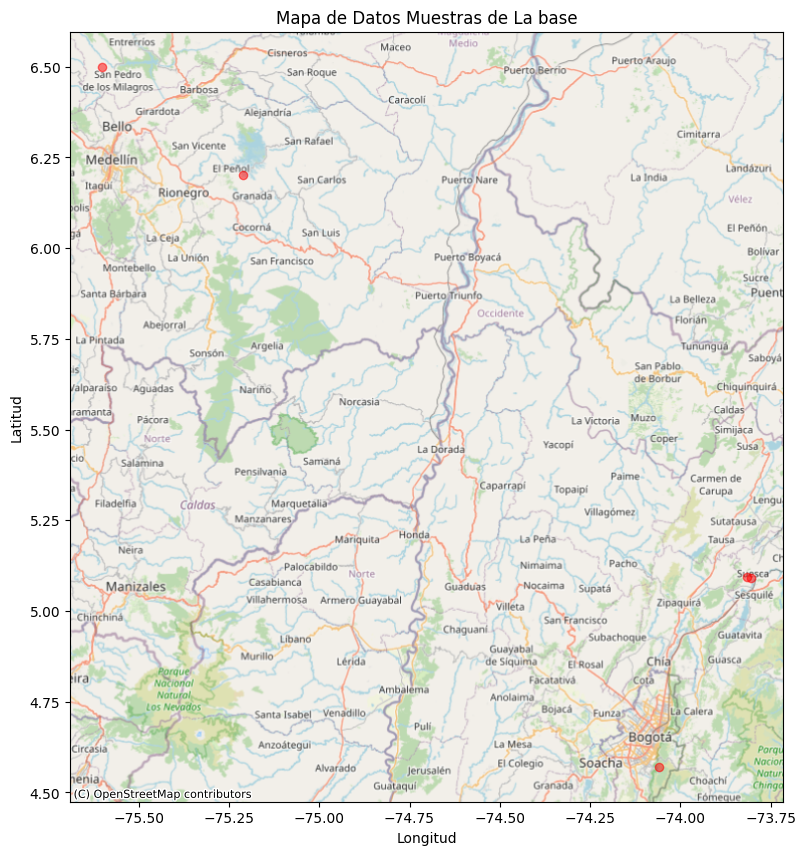

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Mapa de Datos Muestras de La base")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.show()